In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
run_name = 'just_hydro_0m_151121-18-17_38'
filename = f"../data/full/{run_name}/pico.npts"

In [45]:
!ls -lh '{filename}'

-rw-rw-r-- 1 suraj suraj 158M Nov 15 18:17 ../data/full/just_hydro_0m_151121-18-17_38/pico.npts


In [46]:
fs = 1e6
dt = 1.0 / fs

In [47]:
import numpy as np
import struct


from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n

    def __call__(self, data):
        out = np.empty_like(data)
        for i in range(data.shape[1]):
            out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
        return out

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        # out = np.empty_like(data)
        # for i in range(data.shape[1]):
        #     out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
        return np.abs(hilbert(data))

class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename):  # filename: Union[str, path_like, File object]
        self.filename = filename
        self.file = None
        self.band_pass = BP(fs=fs, low=35e3, high=45e3)
        self.envelope = MA(fs=fs, dt=6e-5)
    
    def open(self):
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        if self.file is not None:
            self.close()
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)
            out = self.envelope(np.abs(self.band_pass(arr)))
            # out = self.envelope(np.abs(bp - bp.mean(axis=0)))
            return t, out.astype(arr.dtype)
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

In [48]:
reader = PicoDataLoader(filename)
reader.open()

In [49]:
import itertools
import numpy as np


# TODO: how to deal with multiple sets of zero crossing,
# TODO: groupby can bre replaced my numpy indexing i think
# notes for function def stage_1(signal, winsize_zero_cross, fs, run_plot)
# stage 1 does the following processes:
# 1. filter use IIR bandpass filters
# 2. estimate the zero-crossing of the first peak in two stages
#    first of which is approximate position where first peak crosses the threshold of 10% of signal mean
#    second stage, wherein use curvature of the signal to estimate a more-accurate estimate of zero-crossing
# Availible defaults           500,1e6,                    0,
def Est_ZC_stage_1(signal, winsize, std_noise_multiplier, run_plot=False, plot_title='zero_crossing'):
    def sum_index(index_limit, reshaped_group_results_len):
        ind_count = 0
        for k in range(0, index_limit):
            ind_count = ind_count + reshaped_group_results_len[k]
        return ind_count

    def ZC_estimation(signal_h, noise_threshold, n_max_p):

        # estimate out part of the signal which is > threshold
        results = np.where(signal_h > noise_threshold, True, False)

        # itertools groupby aims to group the array in groups of True and False
        # where g is the groups and k is unique key/ value in each group
        # size/ length of the groups is given by len(list(g)) and is stored as an np.array
        group_results_len = np.array([len(list(g)) for k, g in itertools.groupby(results)])

        # only the first value of each groups (True or False) is stored in this array - will now correspond to each group
        # for which length are estimated previously
        group_results_value = np.array([list(g)[0] for k, g in itertools.groupby(results)])

        # indices & group-length wherein corresponding value in group_results_value is True
        ind_of_group_results_value_for_trues = np.array(np.where(group_results_value == True))
        group_len_counts_of_true = (group_results_len[ind_of_group_results_value_for_trues])

        # indices of top n_max maximuma of group_len_counts_of_true
        ind_n_max_group_len_counts_of_true = np.array(np.argsort(-group_len_counts_of_true))

        # manipulations to match the shape of the arrays
        group_len_counts_of_true = group_len_counts_of_true.T
        ind_n_max_group_len_counts_of_true = ind_n_max_group_len_counts_of_true.T

        # how many maxs (top-n) need to be estimated?
        n_max = int(len(group_len_counts_of_true) * n_max_p / 100)
        if n_max <= 2:
            n_max = int(len(group_len_counts_of_true))

        ind_n_max_group_len_counts_of_true = np.array(ind_n_max_group_len_counts_of_true[0:n_max])

        # what are the values of the top-n (sorted) group-lengths of trues?
        values_maxes_in_group_results_len = np.array((group_len_counts_of_true[ind_n_max_group_len_counts_of_true]))
        values_maxes_in_group_results_len = np.reshape(values_maxes_in_group_results_len, (n_max, 1))

        # manipulations to match the shape of the arrays
        reshaped_group_results_len = np.reshape(group_results_len, (len(group_results_len), 1))

        # elementwise comparison of the arrays to estimate the starting indices of the n_max groups of True:
        # comparison with the entire (true-false) list
        ind_of_max_in_group_results_len = np.array(np.where(np.in1d(reshaped_group_results_len,
                                                                    values_maxes_in_group_results_len)))

        index_max_counts_of_true = np.zeros((len(ind_of_max_in_group_results_len), 1))
        for i in range(len(ind_of_max_in_group_results_len)):
            try:
                index_max_counts_of_true[i] = sum_index(ind_of_max_in_group_results_len[i, 0],
                                                        reshaped_group_results_len) + 1
            except:
                index_max_counts_of_true[i] = 0
                break

        Q_zero_cross_index = (np.min(index_max_counts_of_true[:, 0])).astype(int)

        return Q_zero_cross_index

    def plot_ZC(signal_h, Q_zero_cross_index, plot_title, winsize):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle
        index = Q_zero_cross_index
        fig, axs = plt.subplots(1, figsize=(10,4))
        fig.suptitle(plot_title)
        axs.plot(signal_h, label='bandpass')
        axs.plot(np.repeat(0, len(signal_h)), 'k--', label='zero level')
        axs.plot(np.repeat(noise_threshold_1, len(signal_h)), 'r--', label='noise_threshold_1')
        axs.plot(np.repeat(noise_threshold_2, len(signal_h)), 'b--', label='noise_threshold_2')
        axs.plot(index, signal_h[index], 'o')
        rect = Rectangle((index, 0), winsize * 2, np.max(signal_h) / 2, linewidth=3, edgecolor='r', facecolor='none')
        axs.add_patch(rect)
        axs.legend()

    # filter first and then, normalise the signal for further processing
    # estimate the envelope of the rectified signal using the hilbert transform
    # estimate threshold
    threshold = (np.mean(signal))
    signal_noise_h = np.where(signal > threshold, 0, signal)
    noise_threshold_1 = np.mean(signal_noise_h) + std_noise_multiplier * np.std(signal_noise_h)
    noise_threshold_1 = 700
    # print('noise_threshold_1', noise_threshold_1)

    # first iteration
    n_max_p = 5
    init_est_ZC_index = ZC_estimation(signal, noise_threshold_1, n_max_p)
    # print(f'init_est_ZC_index - {plot_title}', init_est_ZC_index)

    # attempt to check the samples in the neighbourhood
    hori_check_indices = np.linspace(max(init_est_ZC_index - winsize,0), min(init_est_ZC_index + winsize,signal.shape[0] - 1), winsize * 2, dtype=int)
    if np.all(signal[hori_check_indices] < 10 * noise_threshold_1):
        init_est_ZC_index = ZC_estimation(signal, noise_threshold_1 * 2, n_max_p)

    # attempt to check the samples in the neighbourhood by selecting a window with elevated threshold
    noise_threshold_2 = noise_threshold_1 * 1.25
    # print('noise_threshold_2', noise_threshold_2)
    second_est_ZC_index = 0
    if signal[init_est_ZC_index] >= 3 * noise_threshold_1:
        # second iteration
        n_max_p = 50
        sub_signal = signal[init_est_ZC_index - winsize: init_est_ZC_index + winsize]
        ZC_subsignal = ZC_estimation(sub_signal, noise_threshold_2, n_max_p)
        # print(f'ZC_subsignal - {plot_title}', ZC_subsignal)
        second_est_ZC_index = init_est_ZC_index + (ZC_subsignal - winsize)
        # print(f'second_est_ZC_index - {plot_title}', second_est_ZC_index)

    if second_est_ZC_index != 0:
        ZC_index = second_est_ZC_index
    else:
        ZC_index = init_est_ZC_index

    if run_plot:
        plot_ZC(signal, ZC_index, plot_title, winsize)

    return ZC_index


In [50]:
reader.close()
reader.open()
t0 = reader.get()[0]
reader.close()
reader.open()

from tqdm.notebook import tqdm
import subprocess
num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 976.7 + 1)

In [51]:
num_chunks

166

In [52]:
ts = []
arrs = []
t_curr = t0

with tqdm(total=num_chunks, desc=f'{run_name}: ') as progress_bar:
    try:
        for i in range(10000):
            t, arr = reader.get()
            arrs.append(arr)
            index = Est_ZC_stage_1(arr[:, 0], int(0.004 * fs), 200, run_plot=False)
            if index !=0:
                ts.append(t_curr + index * dt)
            t_curr += dt * arr.shape[0]
            progress_bar.update(1)
        else:
            print('Data has more than 100000 sets')
    except StopIteration:
        pass

just_hydro_0m_151121-18-17_38:   0%|          | 0/166 [00:00<?, ?it/s]

In [53]:
y = np.vstack(arrs)
t = np.arange(y.shape[0]) * dt
del arrs
reader.close()
y.shape, y.dtype, y.nbytes * 1e-9, "GB"

((16500000, 5), dtype('int16'), 0.165, 'GB')

In [54]:
ts = np.array(ts) - t0
indices = (ts / dt).astype(int)

In [55]:
np.where(np.diff(ts) < 0.9)

(array([0]),)

In [56]:
ts

array([ 0.42249155,  0.52286863,  2.5724237 ,  3.59474158,  4.62424159,
        5.63719368,  6.66494679,  7.69628072,  8.71636581,  9.73687577,
       10.7675128 , 11.78750587, 12.70875692, 13.8364439 , 14.86033297,
       15.88110089])

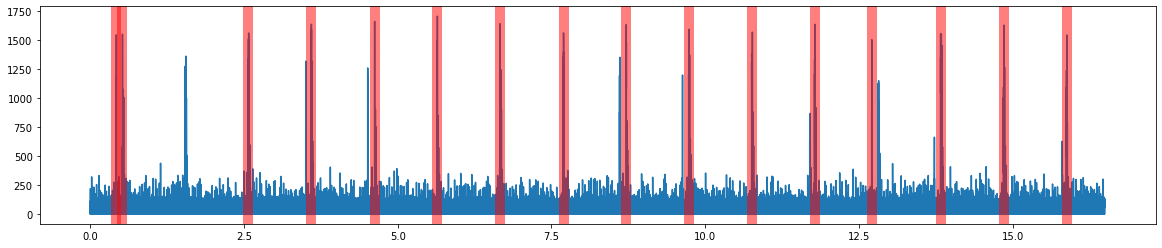

In [62]:
plt.figure(figsize=(20,4))
plt.plot(t, y[:,0])
for x in ts:
    plt.axvline(x=x, color='red', linewidth=10, alpha=0.5)

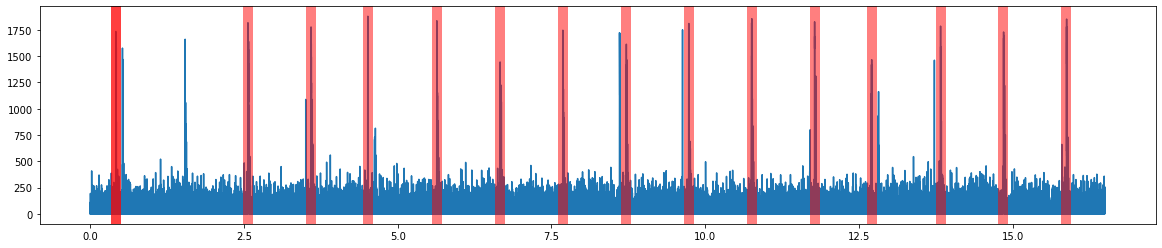

In [68]:
plt.figure(figsize=(20,4))
plt.plot(t, y[:,1])
for x in ts2:
    plt.axvline(x=x, color='red', linewidth=10, alpha=0.5)

In [59]:
ts

array([ 0.42249155,  0.52286863,  2.5724237 ,  3.59474158,  4.62424159,
        5.63719368,  6.66494679,  7.69628072,  8.71636581,  9.73687577,
       10.7675128 , 11.78750587, 12.70875692, 13.8364439 , 14.86033297,
       15.88110089])

In [65]:
ts2 = np.zeros_like(ts)
for i, tt in enumerate(ts):
    index = Est_ZC_stage_1(y[int((tt - 0.1)*fs):int((tt+0.2)*fs), 1], int(0.004 * fs), 200, run_plot=False)
    if index == 0:
        print('fail')
    ts2[i] = tt - 0.1 + index * dt

fail


In [66]:
(ts2 - ts)[ts2 != 0]

array([-7.7890e-03, -9.9999e-02, -9.5650e-03, -7.0610e-03, -1.0000e-01,
       -2.5230e-03, -9.0000e-05, -1.1214e-02, -1.4320e-03, -5.2360e-03,
       -1.1903e-02, -8.8490e-03, -3.5580e-03, -8.7350e-03, -8.6850e-03,
       -5.4870e-03])

In [67]:
ts, ts2

(array([ 0.42249155,  0.52286863,  2.5724237 ,  3.59474158,  4.62424159,
         5.63719368,  6.66494679,  7.69628072,  8.71636581,  9.73687577,
        10.7675128 , 11.78750587, 12.70875692, 13.8364439 , 14.86033297,
        15.88110089]),
 array([ 0.41470255,  0.42286963,  2.5628587 ,  3.58768058,  4.52424159,
         5.63467068,  6.66485679,  7.68506672,  8.71493381,  9.73163977,
        10.7556098 , 11.77865687, 12.70519892, 13.8277089 , 14.85164797,
        15.87561389]))